## Installations and imports

In [23]:
'''
! pip install TextBlob
! pip install nltk
! pip install transformers
! python -m spacy download en_core_web_sm
! pip uninstall scikit-learn -y
! pip install --no-cache-dir scikit-learn
'''

'\n! pip install TextBlob\n! pip install nltk\n! pip install transformers\n! python -m spacy download en_core_web_sm\n! pip uninstall scikit-learn -y\n! pip install --no-cache-dir scikit-learn\n'

In [24]:
import json
import nltk
import re
import string
import spacy
import transformers

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd

from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from transformers import pipeline
from sklearn.metrics.pairwise import cosine_similarity

In [25]:
# Baixar recursos do NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')


[nltk_data] Downloading package punkt to /home/ana/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/ana/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/ana/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/ana/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

## Dataset overview

In [26]:
def load_yelp_data(file_path, nrows=None):
    data = []
    print(f" Loading: {file_path}...")  

    with open(file_path, "r", encoding="utf-8") as f:
        for i, line in enumerate(f):
            if nrows and i >= nrows:
                break
            data.append(json.loads(line))
            
            if (i + 1) % 100000 == 0:
                print(f"  🔄 {i + 1} loaded lines...")

    print(f" {file_path} loaded with {len(data)} lines!\n")  
    return pd.DataFrame(data)

print("\n Starting to load datasets...\n")




 Starting to load datasets...



In [27]:
df_business = load_yelp_data("data/yelp_academic_dataset_business.json")

 Loading: data/yelp_academic_dataset_business.json...
  🔄 100000 loaded lines...
 data/yelp_academic_dataset_business.json loaded with 150346 lines!



In [28]:
city_restaurants = df_business[
    (df_business['city'].str.lower() == 'sparks') &
    (df_business['categories'].str.contains('Restaurants', na=False))
]

In [29]:
'''
city_business_ids = set(city_restaurants['business_id'])
filtered_reviews = []

with open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:
    for line in f:
        review = json.loads(line)
        if review['business_id'] in city_business_ids:
            filtered_reviews.append(review)

restaurant_reviews = pd.DataFrame(filtered_reviews)

with open('data/sparks_reviews.json', 'w', encoding='utf-8') as out_file:
    for review in filtered_reviews:
        out_file.write(json.dumps(review) + '\n')
'''

"\ncity_business_ids = set(city_restaurants['business_id'])\nfiltered_reviews = []\n\nwith open('data/yelp_academic_dataset_review.json', 'r', encoding='utf-8') as f:\n    for line in f:\n        review = json.loads(line)\n        if review['business_id'] in city_business_ids:\n            filtered_reviews.append(review)\n\nrestaurant_reviews = pd.DataFrame(filtered_reviews)\n\nwith open('data/sparks_reviews.json', 'w', encoding='utf-8') as out_file:\n    for review in filtered_reviews:\n        out_file.write(json.dumps(review) + '\n')\n"

In [30]:
df_review = load_yelp_data("data/sparks_reviews.json")

 Loading: data/sparks_reviews.json...
 data/sparks_reviews.json loaded with 40186 lines!



In [31]:
city_restaurants.count()


business_id     334
name            334
address         334
city            334
state           334
postal_code     334
latitude        334
longitude       334
stars           334
review_count    334
is_open         334
attributes      331
categories      334
hours           295
dtype: int64

In [32]:
df_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [33]:
df_business.shape

(150346, 14)

In [34]:
df_business.describe()

,latitude,longitude,stars,review_count,is_open
count,150346.000000,150346.000000,150346.000000,150346.000000,150346.00000
mean,36.671150,-89.357339,3.596724,44.866561,0.79615
std,5.872759,14.918502,0.974421,121.120136,0.40286
min,27.555127,-120.095137,1.000000,5.000000,0.00000
25%,32.187293,-90.357810,3.000000,8.000000,1.00000
50%,38.777413,-86.121179,3.500000,15.000000,1.00000
75%,39.954036,-75.421542,4.500000,37.000000,1.00000
max,53.679197,-73.200457,5.000000,7568.000000,1.00000


In [35]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25


In [36]:
df_review.shape

(40186, 9)

In [37]:
df_review.describe()

,stars,useful,funny,cool
count,40186.000000,40186.000000,40186.000000,40186.000000
mean,3.594038,1.277709,0.306574,0.691086
std,1.542312,2.868504,1.315701,2.242514
min,1.000000,0.000000,0.000000,0.000000
25%,2.000000,0.000000,0.000000,0.000000
50%,4.000000,0.000000,0.000000,0.000000
75%,5.000000,2.000000,0.000000,1.000000
max,5.000000,217.000000,103.000000,201.000000


## Pre-processing

In [38]:
nlp = spacy.load("en_core_web_sm", disable=["parser", "ner"])

def preprocess_text(text):
    text = text.lower().strip()  # Lowercase and remove extra spaces

    # Remove special characters but keep numbers
    text = re.sub(r'[^a-zA-Z0-9 ]', '', text)

    # Tokenization, stopword removal, and lemmatization
    doc = nlp(text)
    tokens = [token.lemma_ for token in doc if not token.is_stop]

    return " ".join(tokens)


In [39]:
df_review["clean_text"] = df_review["text"].apply(preprocess_text)
print(" pre-processin finished!")


 pre-processin finished!


In [40]:
df_review.head()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date,clean_text
0,LkXdUnLG55HUqClm5C-FRQ,Bcwv94u7FgNCpCoJLmSsaA,l4aS1QVy_bGnwUXSJzpbsw,5.0,0,0,1,Best pizza ever... hands down.\n\nLove the pee...,2009-08-04 22:21:20,good pizza hand downlove peep run place hock...
1,Z_tQ-hruQRU45Rg3XglyJQ,9wymgENHBBOm9Tlx7xHy7A,HZtkTPfSshfRjpQR7x1Raw,2.0,0,0,0,I didn't really like my sandwich I got here. I...,2014-03-14 23:13:32,not like sandwich get get jalapeo cheese bread...
2,r34W_h6NEMvBIpT2h53GQw,p0tP-O8y7rhJKd1iFirgwQ,t0XZeA0MP0P66QyLQn_NUw,5.0,0,0,0,This is a must get when you come to Reno is Ye...,2016-07-15 07:24:31,come reno yellow sub ask sprout sub will not r...
3,P6Kbftcn5GwvIo2xQyXFBg,fSR8LJJ0Aa3w8HoaGyXYCA,UX3eq0WsVva-cqlVrzyzFg,5.0,0,0,0,"Yummy food, they will veganize things for you...",2013-12-28 22:22:19,yummy food veganize thing server friendly re...
4,wXcsMgO27jDlr_8xuhn-pQ,CqRAt1eogaHCBBtF_shemg,ruFtZKwlJASx5BTk1dh5AQ,5.0,0,0,0,The new Bacon-Bleu cheeseburger is excellent! ...,2010-03-14 05:14:25,new baconbleu cheeseburger excellent probably ...


## Explore the Data

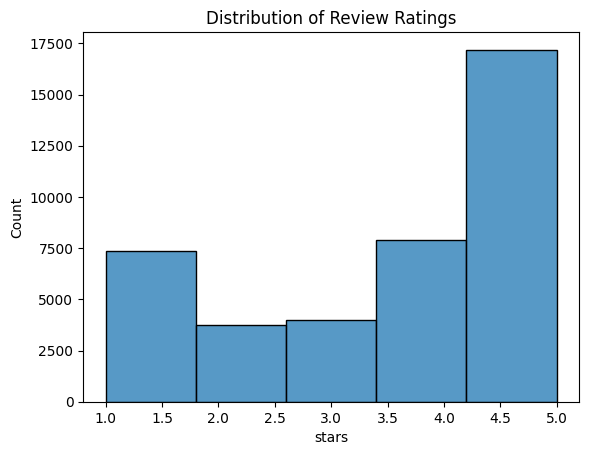

In [41]:
sns.histplot(df_review['stars'], bins=5)
plt.title("Distribution of Review Ratings")
plt.show()

## Simple User-Based Recommendation System

In [ ]:
user_restaurant_matrix = df_review.pivot_table(
    index='user_id', 
    columns='business_id', 
    values='stars'
)

user_matrix_filled = user_restaurant_matrix.fillna(0)
user_similarity = cosine_similarity(user_matrix_filled)

user_similarity_df = pd.DataFrame(
    user_similarity, 
    index=user_restaurant_matrix.index, 
    columns=user_restaurant_matrix.index
)

def recommend_restaurants_for_user(target_user_id, top_n=5):
    if target_user_id not in user_similarity_df:
        return []

    similar_users = user_similarity_df[target_user_id].sort_values(ascending=False)[1:11]
    similar_users_ids = similar_users.index

    target_user_rated = user_restaurant_matrix.loc[target_user_id].dropna().index
    recommendations = user_restaurant_matrix.loc[similar_users_ids].mean().drop(target_user_rated, errors='ignore')
    top_recommendations = recommendations.sort_values(ascending=False).head(top_n)

    return city_restaurants[city_restaurants['business_id'].isin(top_recommendations.index)][['name', 'stars', 'review_count']]